In [138]:
import numpy as np
from tensorflow.keras.datasets import cifar10
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
from collections import Counter

In [139]:
'''
Data Preprocessing
1. Retrieve and load CIFAR 10 dataset from keras dataset.
'''
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

In [140]:
'''
2. Obtain only the first 5,000 instances from X_train and y_train.
'''
X_train = X_train[:5000]
y_train = y_train[:5000]

In [141]:
'''
3. Preprocess the Image Dataset (Flatten & Normalize) 
'''
X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

In [142]:
X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)

In [143]:
X_train.shape

(5000, 3072)

In [144]:
'''
PCA
1. Apply PCA to the preprocessed and preserve 99% of the variance to create a reduced dataset.
'''
pca = PCA(n_components=0.99)
X_train_pca = pca.fit_transform(X_train)

In [145]:
'''
2. Print and display the shape of the reduced dataset. 
'''
print("Shape of the reduced dataset:", X_train_pca.shape)

Shape of the reduced dataset: (5000, 592)


In [146]:
'''
3. Recover the Original Images
'''
X_train_recovered = pca.inverse_transform(X_train_pca)

X_train_recovered = X_train_recovered.reshape(5000, 32, 32, 3)

X_train_recovered = (X_train_recovered * 255).astype(np.uint8)

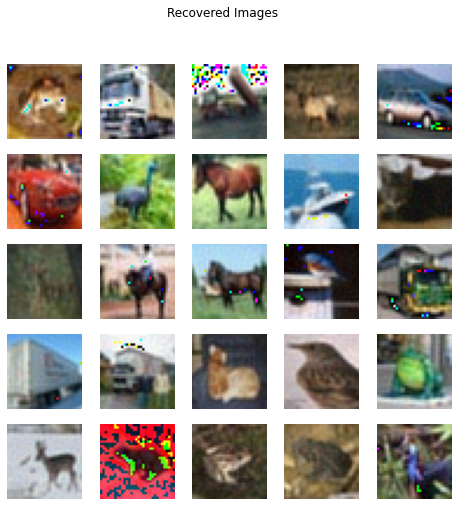

In [147]:
'''
4. Plot any 25 recovered images in a 5x5 grid (5 images per row and 5 images per column). 
'''
def plot_images(images, title):
    plt.figure(figsize=(8, 8))
    for i in range(25):
        plt.subplot(5, 5, i+1)
        plt.imshow(images[i])
        plt.axis('off')
    plt.suptitle(title)
    plt.show()
    
plot_images(X_train_recovered[:25], "Recovered Images")

In [148]:
'''
5. Apply PCA Again -Reduce the dimensionality to 2.
'''
pca_2d = PCA(n_components=2)
X_train_pca_2d = pca_2d.fit_transform(X_train)

In [175]:
pca_2d.explained_variance_ratio_

array([0.29194355, 0.11245148], dtype=float32)

In [149]:
print("Shape of the 2D PCA-reduced dataset:", X_train_pca_2d.shape)

Shape of the 2D PCA-reduced dataset: (5000, 2)


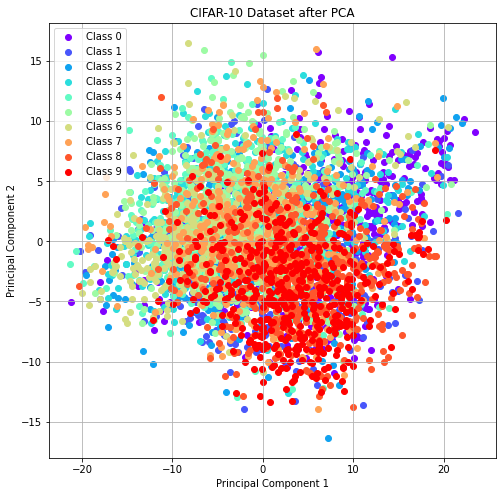

In [150]:
'''
6. Visualize the data in the new 2-dimensional PCA space. 
(Plot the 2 principal components). Use the y_train labels for coloring and include a legend in the plot. 
Save the plot as CIFAR-10 _Dataset _after_ PCA. 
'''
def plot_pca_2d(X_pca, y, title):
    plt.figure(figsize=(8, 8))
    colors = cm.rainbow(np.linspace(0, 1, 10)) 
    for i in range(10):  # 10 classes (0 to 9)
        plt.scatter(X_pca[y_train.flatten() == i, 0], 
                    X_pca[y_train.flatten() == i, 1], 
                    color=colors[i], label=f'Class {i}')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.title(title)
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()

plot_pca_2d(X_train_pca_2d, y_train, "CIFAR-10 Dataset after PCA")

In [151]:
plt.savefig("CIFAR-10_Dataset_after_PCA.png")

<Figure size 432x288 with 0 Axes>

In [152]:
'''
DBSCAN Clustering
1.  Create a User-Defined Function to perform DBSCAN 
    on the given data (reduced dataset from step 5) with a range of eps values.
2. Print the best eps and the optimal number of clusters. 
3. Feel free to use and tune hyperparameters based on performance. 
'''
def perform_dbscan_with_silhouette(X, eps_values, min_samples, metric):
    best_eps = None
    best_num_clusters = -1
    best_silhouette = -1
    best_labels = None
    silhouette_scores = []  
    
    for eps in eps_values:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples, metric=metric)
        labels = dbscan.fit_predict(X)
        
        # excluding noise -1
        num_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        
        # Clusters are more than two excluding noise?
        if num_clusters > 1:
            try:
                silhouette_avg = silhouette_score(X, labels, metric='euclidean')
                silhouette_scores.append(silhouette_avg)  
            except ValueError:
                silhouette_scores.append(float('nan'))  
                continue
            
            if silhouette_avg > best_silhouette:
                best_silhouette = silhouette_avg
                best_eps = eps
                best_num_clusters = num_clusters
                best_labels = labels
        else:
            silhouette_scores.append(float('nan'))  

    return best_eps, best_num_clusters, best_labels, silhouette_scores

In [153]:
eps_values = np.linspace(0.5, 5, 100)

In [154]:
'''
min_smamples = 5
euclidean 
'''
best_eps1, best_num_clusters1, best_labels1, silhouette_scores1 = perform_dbscan_with_silhouette(X_train_pca_2d, eps_values, 5, 'euclidean')

In [155]:
print(f"Best eps: {best_eps1}")
print(f"Optimal number of clusters: {best_num_clusters1}")
print(f"Number of noises: {list(best_labels1).count(-1)}")
print(f'label_counts: {Counter(best_labels1)}')
print(len(list(best_labels1)))

Best eps: 1.6818181818181819
Optimal number of clusters: 2
Number of noises: 21
label_counts: Counter({0: 4975, -1: 21, 1: 4})
5000


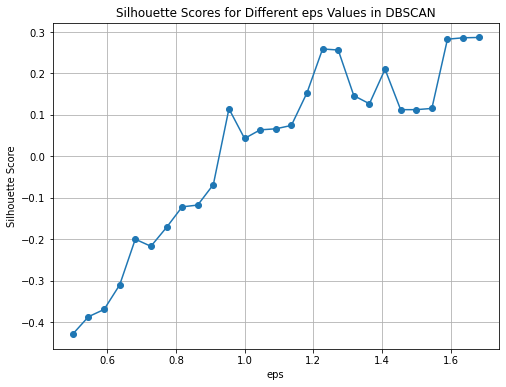

In [156]:
plt.figure(figsize=(8, 6))
plt.plot(eps_values, silhouette_scores1, marker='o')
plt.title('Silhouette Scores for Different eps Values in DBSCAN')
plt.xlabel('eps')
plt.ylabel('Silhouette Score')
plt.grid(True)
plt.show()

In [157]:
print(silhouette_scores1)

[-0.42890742, -0.38719273, -0.36972702, -0.31037384, -0.20011182, -0.2172621, -0.17171285, -0.12210398, -0.1177027, -0.068261586, 0.114670046, 0.04301224, 0.06384524, 0.06631886, 0.07451821, 0.15327355, 0.2590478, 0.2565272, 0.14640474, 0.12686892, 0.21011065, 0.112550534, 0.112550534, 0.11552461, 0.28268278, 0.2860311, 0.28682595, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]


In [158]:
'''
min_smamples = 5
manhattan
'''

best_eps2, best_num_clusters2, best_labels2, silhouette_scores2 = perform_dbscan_with_silhouette(X_train_pca_2d, eps_values, 5, 'manhattan')

In [159]:
print(f"Best eps: {best_eps2}")
print(f"Optimal number of clusters: {best_num_clusters2}")
print(f"Number of noises: {list(best_labels2).count(-1)}")
print(f'label_counts: {Counter(best_labels2)}')
print(len(list(best_labels2)))

Best eps: 2.1363636363636367
Optimal number of clusters: 2
Number of noises: 23
label_counts: Counter({0: 4972, -1: 23, 1: 5})
5000


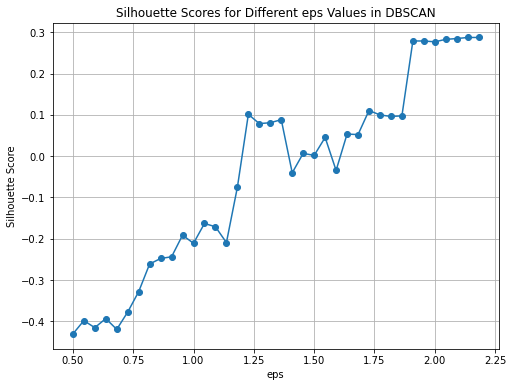

In [160]:
plt.figure(figsize=(8, 6))
plt.plot(eps_values, silhouette_scores2, marker='o')
plt.title('Silhouette Scores for Different eps Values in DBSCAN')
plt.xlabel('eps')
plt.ylabel('Silhouette Score')
plt.grid(True)
plt.show()

In [161]:
print(silhouette_scores2)

[-0.43076417, -0.39846772, -0.41539702, -0.39349142, -0.4195868, -0.37761998, -0.3283065, -0.26115298, -0.24793322, -0.24375029, -0.19149505, -0.21108, -0.16300212, -0.17112371, -0.20940879, -0.075339474, 0.101262026, 0.07877927, 0.08099048, 0.08831234, -0.040318836, 0.006772145, 0.0017604696, 0.045256462, -0.03454304, 0.053530693, 0.052227773, 0.11056226, 0.099888414, 0.09616053, 0.09755391, 0.27897227, 0.27897227, 0.2769158, 0.28293535, 0.284788, 0.28748092, 0.287452, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]


In [162]:
'''
min_smamples = 3
euclidean 
'''
best_eps3, best_num_clusters3, best_labels3, silhouette_scores3 = perform_dbscan_with_silhouette(X_train_pca_2d, eps_values, 3, 'euclidean')

In [163]:
print(f"Best eps: {best_eps3}")
print(f"Optimal number of clusters: {best_num_clusters3}")
print(f"Number of noises: {list(best_labels3).count(-1)}")
print(f'label_counts: {Counter(best_labels3)}')
print(len(list(best_labels3)))

Best eps: 1.5
Optimal number of clusters: 3
Number of noises: 20
label_counts: Counter({0: 4974, -1: 20, 1: 3, 2: 3})
5000


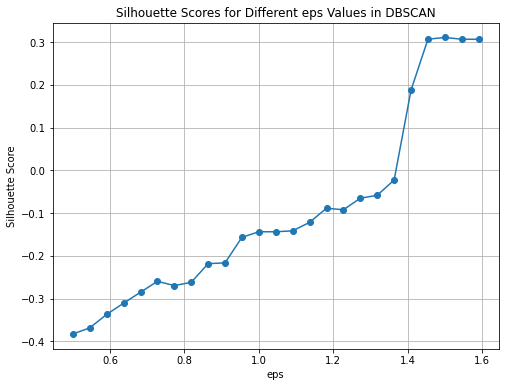

In [164]:
plt.figure(figsize=(8, 6))
plt.plot(eps_values, silhouette_scores3, marker='o')
plt.title('Silhouette Scores for Different eps Values in DBSCAN')
plt.xlabel('eps')
plt.ylabel('Silhouette Score')
plt.grid(True)
plt.show()

In [165]:
print(silhouette_scores3)

[-0.38257274, -0.36823437, -0.33687672, -0.31051385, -0.28502598, -0.25946277, -0.26948413, -0.2618331, -0.21818458, -0.21631822, -0.15657431, -0.14362362, -0.14362362, -0.14144637, -0.12156997, -0.088605076, -0.09222006, -0.06517501, -0.05835287, -0.022574704, 0.1877231, 0.30655235, 0.31060243, 0.30648053, 0.30648053, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]


In [166]:
best_eps4, best_num_clusters4, best_labels4, silhouette_scores4 = perform_dbscan_with_silhouette(X_train_pca_2d, eps_values, 3, 'manhattan')

In [167]:
print(f"Best eps: {best_eps4}")
print(f"Optimal number of clusters: {best_num_clusters4}")
print(f"Number of noises: {list(best_labels4).count(-1)}")
print(f'label_counts: {Counter(best_labels4)}')
print(len(list(best_labels4)))

Best eps: 2.0454545454545454
Optimal number of clusters: 2
Number of noises: 19
label_counts: Counter({0: 4978, -1: 19, 1: 3})
5000


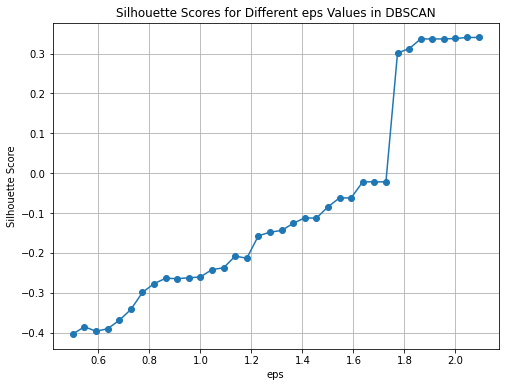

In [168]:
plt.figure(figsize=(8, 6))
plt.plot(eps_values, silhouette_scores4, marker='o')
plt.title('Silhouette Scores for Different eps Values in DBSCAN')
plt.xlabel('eps')
plt.ylabel('Silhouette Score')
plt.grid(True)
plt.show()

In [169]:
print(silhouette_scores4)

[-0.40356782, -0.38546953, -0.39682013, -0.3904198, -0.3692649, -0.34210625, -0.299296, -0.27725208, -0.2638446, -0.26471615, -0.262649, -0.26036856, -0.24195825, -0.23746431, -0.20823261, -0.21338372, -0.1572261, -0.1481324, -0.14382032, -0.12598106, -0.11212376, -0.112925634, -0.08447524, -0.06206964, -0.062197033, -0.021733312, -0.021733312, -0.021930594, 0.30166036, 0.31240797, 0.33685356, 0.33685356, 0.33685356, 0.337956, 0.34054813, 0.34054813, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]


In [170]:
def plot_dbscan_clusters(X_pca, labels, title="DBSCAN Clusters"):
    unique_labels = set(labels)
    plt.figure(figsize=(10, 8))
    
    colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
    
    for k, color in zip(unique_labels, colors):
        if k == -1:
            # Black color for noise points
            color = [0, 0, 0, 1]
        
        class_member_mask = (labels == k)
        
        # Plot data points for each cluster
        xy = X_pca[class_member_mask]
        plt.scatter(xy[:, 0], xy[:, 1], c=[color], label=f'Cluster {k}' if k != -1 else 'Noise', s=20)
    
    plt.title(title)
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()

    # Save the plot as PNG
    plt.savefig("CIFAR-10_Clusters_after_DBSCAN.png")

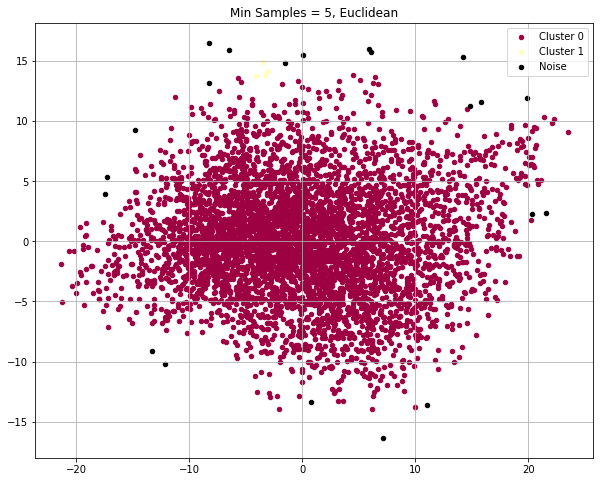

<Figure size 432x288 with 0 Axes>

In [171]:
plot_dbscan_clusters(X_train_pca_2d, best_labels1, "Min Samples = 5, Euclidean")

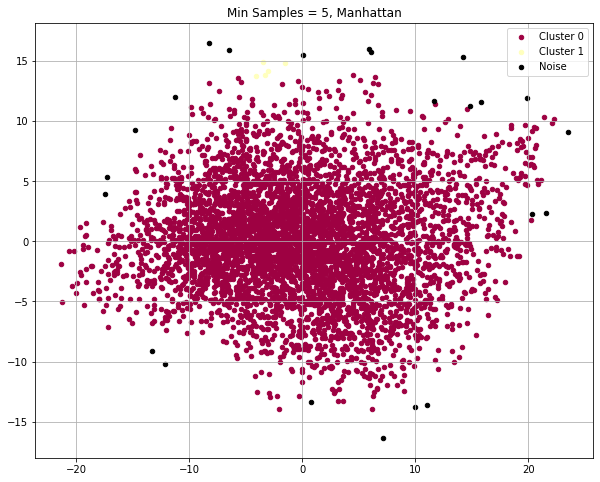

<Figure size 432x288 with 0 Axes>

In [172]:
plot_dbscan_clusters(X_train_pca_2d, best_labels2, "Min Samples = 5, Manhattan")

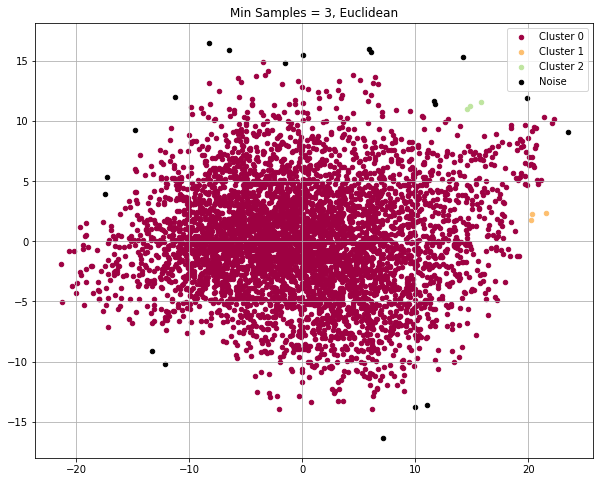

<Figure size 432x288 with 0 Axes>

In [173]:
plot_dbscan_clusters(X_train_pca_2d, best_labels3, "Min Samples = 3, Euclidean")

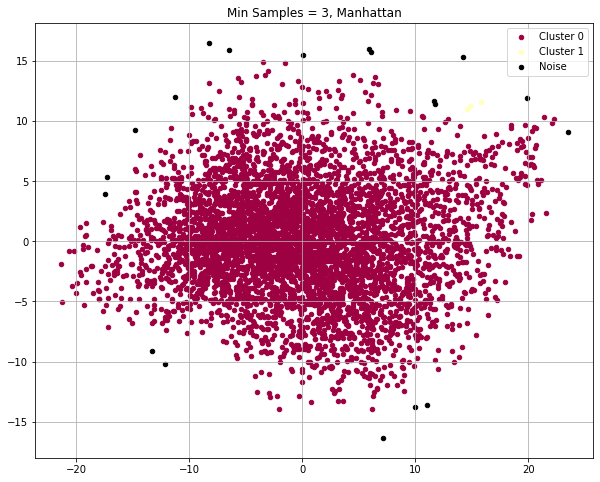

<Figure size 432x288 with 0 Axes>

In [174]:
plot_dbscan_clusters(X_train_pca_2d, best_labels4, "Min Samples = 3, Manhattan")